In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
%matplotlib inline

### 1.前10对网络关联

In [2]:
#step1.读取上市公司和子公司数据，并进行连接
df_com = pd.read_excel(r'../../file/subject/chapter3/SSGScompany04.xlsx')
df_son = pd.read_excel(r'../../file/subject/chapter3/company_info_all05.xlsx')
df = pd.merge(df_son,df_com,left_on='上市公司名称',right_on='公司名称2').reset_index()

In [3]:
#step2.筛选正常营业公司
df['公司状态'] = df['公司状态'].apply(lambda x:'开业' if x == 0 else x)
df = df[-df['公司状态'].str.startswith('吊销')]

In [4]:
df.columns

Index(['index', 'Unnamed: 0_x', '公司名称_x', '上市公司名称', '公司状态', '注册资本', '上市公司投资比例',
       'province_x', 'city_x', 'Unnamed: 0_y', 'Unnamed: 0.1', '公司名称_y', '地址',
       '公司网址', '爬取页', '公司名称2', 'region', 'province_y', 'city_y'],
      dtype='object')

In [68]:
#step3.筛选非同城公司以建立关联
city_net = df[['city_x','city_y']].rename(columns={'city_x':'ZGS_city','city_y':'SSGS_city'})
city_net['count'] = 1
city_net = city_net[-(city_net['ZGS_city'] == city_net['SSGS_city'])]

In [69]:
#step4.处理错误城市数据
city_net = city_net[-(city_net.ZGS_city.isin([0,'','']) | city_net.ZGS_city.isna())]
city_net.ZGS_city = city_net.ZGS_city.apply(lambda x:np.nan if x.isascii() else x)
city_net.dropna(inplace=True)

In [76]:
#step5.聚合城市数据，统计连接次数，筛选出前N条连接
city_net = city_net.groupby(by=['SSGS_city','ZGS_city']).sum().reset_index()
city_net_10 = city_net.sort_values(by='count',ascending=False).head(10)
city_net_10

,SSGS_city,ZGS_city,count
1136,北京市,深圳市,885
952,北京市,上海市,423
181,上海市,深圳市,270
1026,北京市,天津市,239
5267,深圳市,北京市,224
5241,深圳市,上海市,218
1110,北京市,武汉市,176
1073,北京市,成都市,169
1225,北京市,重庆市,166
68,上海市,北京市,142


In [99]:
#step6.利用集合去重，便于获取城市坐标
city_lst = []
for i in ['ZGS_city','SSGS_city']:
    for j in city_net_10[i]:
        city_lst.append(j)
city_lst = list(set(city_lst))
city_lst = pd.DataFrame(city_lst,columns=['city'])
city_lst

,city
0,武汉市
1,北京市
2,天津市
3,成都市
4,重庆市
5,上海市
6,深圳市


In [96]:
#step7.读取城市经纬度坐标文件
coor = pd.read_csv(r'../../file/subject/chapter3/coor_xian80.csv',names=['city','lng','lat'])
coor.head()

,city,lng,lat
NaN,0,1.000000e+00,2.000000e+00
0.0,上海市,1.792842e+06,3.533533e+06
1.0,临沧市,-3.498802e+05,2.673621e+06
2.0,丽江市,-2.437366e+05,3.003028e+06
3.0,保山市,-4.141199e+05,2.794030e+06


In [102]:
#step8.合并获取前N城市坐标,注意使用交集模式
data = pd.merge(city_lst,coor,how='inner')
data

,city,lng,lat
0,武汉市,1.108630e+06,3.406388e+06
1,北京市,1.216768e+06,4.484032e+06
2,天津市,1.306489e+06,4.392975e+06
3,成都市,9.982355e+04,3.405324e+06
4,重庆市,4.868969e+05,3.326107e+06
5,上海市,1.792842e+06,3.533533e+06
6,深圳市,1.126794e+06,2.514053e+06


In [107]:
#step9.将城市经纬度转换为字典格式
city_dict = data.set_index('city').T.to_dict('list')
city_dict

{'武汉市': [1108630.36966, 3406387.83387],
 '北京市': [1216767.7121, 4484032.32077],
 '天津市': [1306488.96343, 4392975.06048],
 '成都市': [99823.54524810001, 3405323.68659],
 '重庆市': [486896.904117, 3326107.06099],
 '上海市': [1792842.2295900001, 3533532.88806],
 '深圳市': [1126793.91842, 2514052.77349]}

In [108]:
#step10.获取城市列表，便于图上标注
city_lst_all = []
for i in ['ZGS_city','SSGS_city']:
    for j in city_net[i]:
        city_lst_all.append(j)

In [151]:
#step11.获取连接线宽度和节点大小参数
dic = {}
node_lst = []
node_size = []
edge_width = []
for i in city_lst['city']:
    dic[i] = city_lst_all.count(i)
for k,v in dic.items():
    node_lst.append(k)
    node_size.append(v*5)
    edge_width.append(v/20)

C:\Users\cc\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


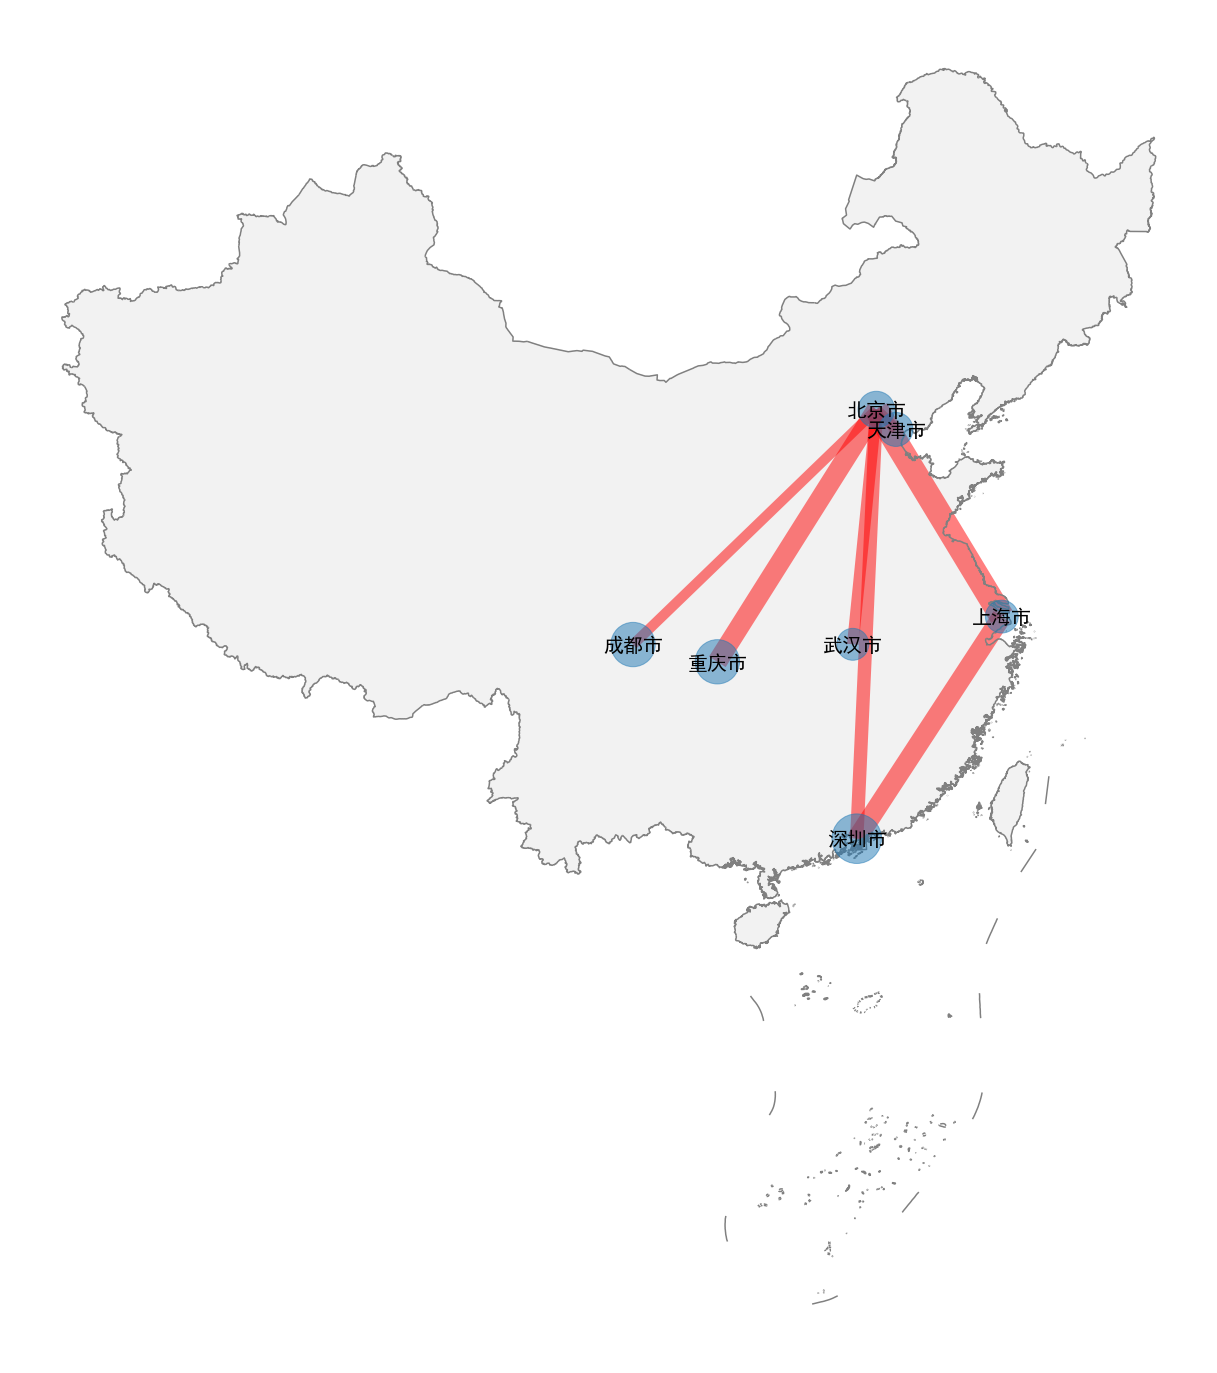

In [179]:
#step12.生成中国地图
fig,ax = plt.subplots(figsize=(25,25))
#去掉边框
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

country = gpd.GeoDataFrame.from_file(r'../../file/subject/chapter3/china.shp')
country = country.to_crs("EPSG:2381")
country.plot(ax=ax,color='#f2f2f2',edgecolor='#f2f2f2')
country2 = gpd.GeoDataFrame.from_file(r'../../file/subject/chapter3/china_arc.shp')
country2 = country2.to_crs("EPSG:2381")
country2.plot(ax=ax,color='gray')

#step13.最终networkx图像生成
labels = {}
for k,v in dic.items():
    if v > 100:
        labels[k] = k
GA = nx.from_pandas_edgelist(city_net_10,source='SSGS_city',target='ZGS_city',edge_attr='count')
pos = city_dict

nx.draw(GA,pos,font_family='SimHei',node_size=0,width=0,alpha=0.5)
nx.draw_networkx_edges(GA,pos,width=edge_width,alpha=0.5,edge_color='r')
nx.draw_networkx_labels(GA,pos,labels=labels,font_family='SimHei',font_size='20')
nx.draw_networkx_nodes(GA,pos,node_size=node_size,alpha=0.5)
plt.show()

### 2.前50对网络关联

### 3.前100对网络关联